# Notebook 4: Assessment and Evaluation
## Introduction
# Loads models/data from Notebook 3, evaluates on test set with MAE/RMSE/AQI metrics, XAI via SHAP.
# Justification: MAE/RMSE for regression accuracy; weighted F1 for imbalanced AQI classes. SHAP for interpretability in sustainability apps.


In [4]:
# Mount Google Drive
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Define your project folder in Google Drive
your_project_path = '/content/drive/My Drive/AI_Sustainability_Project_lsa'

# Create the project directory if it doesn't exist
os.makedirs(your_project_path, exist_ok=True)
print(f"Project path set to: {your_project_path}")

# Change current working directory to your project path
%cd "{your_project_path}"

# Verify current working directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path set to: /content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
compression_results_enhanced.csv
compression_summary.html
correlation_matrix_full.csv
evaluation_results_summary.csv
featured_data_for_models.csv
images
lstm_cm_h12.png
lstm_cm_h1.png
lstm_cm_h24.png
lstm_cm_h3.png
lstm_cm_h6.png
lstm_f16_h6.h5
lstm_model_h12.h5
lstm_model_h12.keras
lstm_model_h1.h5
lstm_model_h1.keras
lstm_model_h24.h5
lstm_model_h24.keras
lstm_model_h3.h5
lstm_model_h3.keras
lstm_model_h6.h5
lstm_model_h6.keras
lstm_original_h6.h5
lstm_tflite_dynamic_h6.tflite
preds_h12.png
preds_h1.png
preds_h24.png
preds_h3.png
preds_h6.png
rf_cm_h12.png
rf_cm_h1.png
rf_cm_h24.png
rf_cm_h3.png
rf_cm_h6.png
rf_feature_selected_h6.pkl
rf_model_h12.pkl
rf_model_h1.pkl
rf_model_h

--- Starting Assessment and Evaluation (Notebook 4) ---
Loaded test featured data successfully. Shape: (805, 48)
Columns in loaded data: ['pm25_value', 'temp', 'humidity', 'wind_speed', 'wind_dir', 'precipitation', 'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'pm25_value_lag_1', 'pm25_value_lag_3', 'pm25_value_lag_6', 'pm25_value_lag_12', 'pm25_value_lag_24', 'pm25_value_lag_48', 'temp_lag_1', 'temp_lag_3', 'temp_lag_6', 'temp_lag_12', 'temp_lag_24', 'temp_lag_48', 'humidity_lag_1', 'humidity_lag_3', 'humidity_lag_6', 'humidity_lag_12', 'humidity_lag_24', 'humidity_lag_48', 'wind_speed_lag_1', 'wind_speed_lag_3', 'wind_speed_lag_6', 'wind_speed_lag_12', 'wind_speed_lag_24', 'wind_speed_lag_48', 'precipitation_lag_1', 'precipitation_lag_3', 'precipitation_lag_6', 'precipitation_lag_12', 'precipitation_lag_24', 'precipitation_lag_48', 'pm25_rolling_24', 'temp_rolling_24', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'wind_humidity_interaction', 'target_h']
Featur

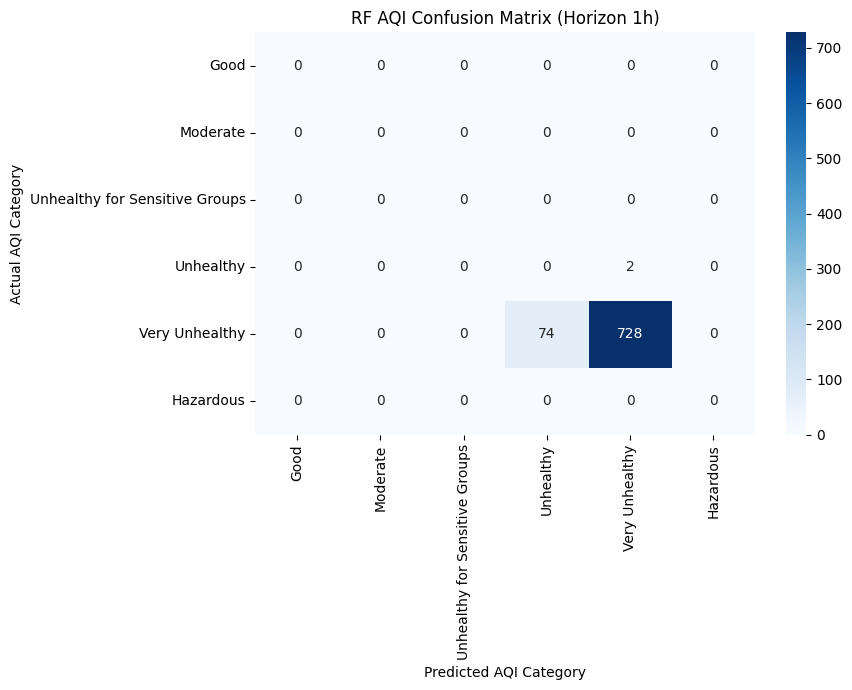

RF Horizon 1: MAE=0.48, RMSE=2.06, AQI Acc=0.91, AQI F1=0.95
Evaluating LSTM Neural Network for horizon 1...


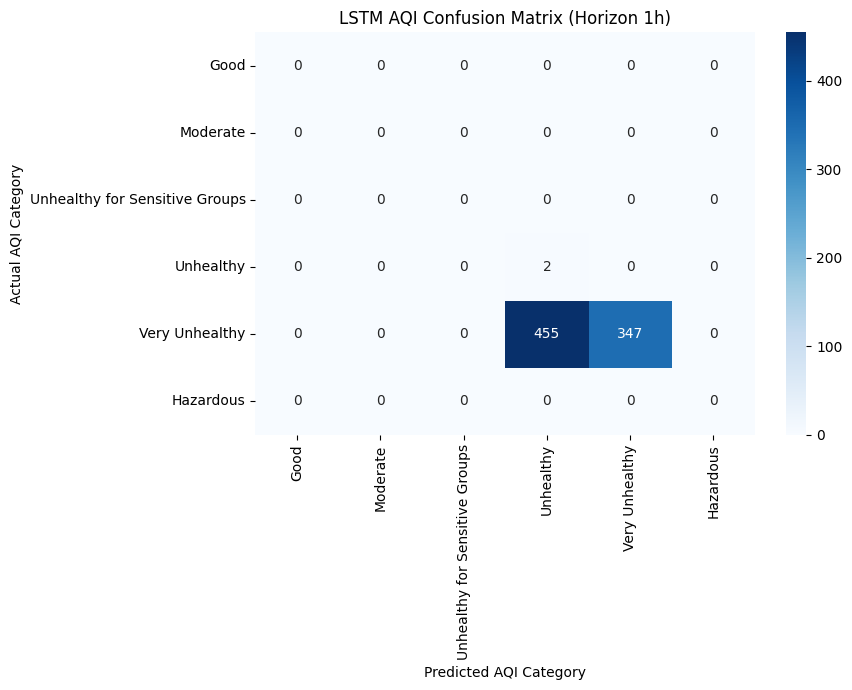

LSTM Horizon 1: MAE=0.58, RMSE=1.10, AQI Acc=0.43, AQI F1=0.60


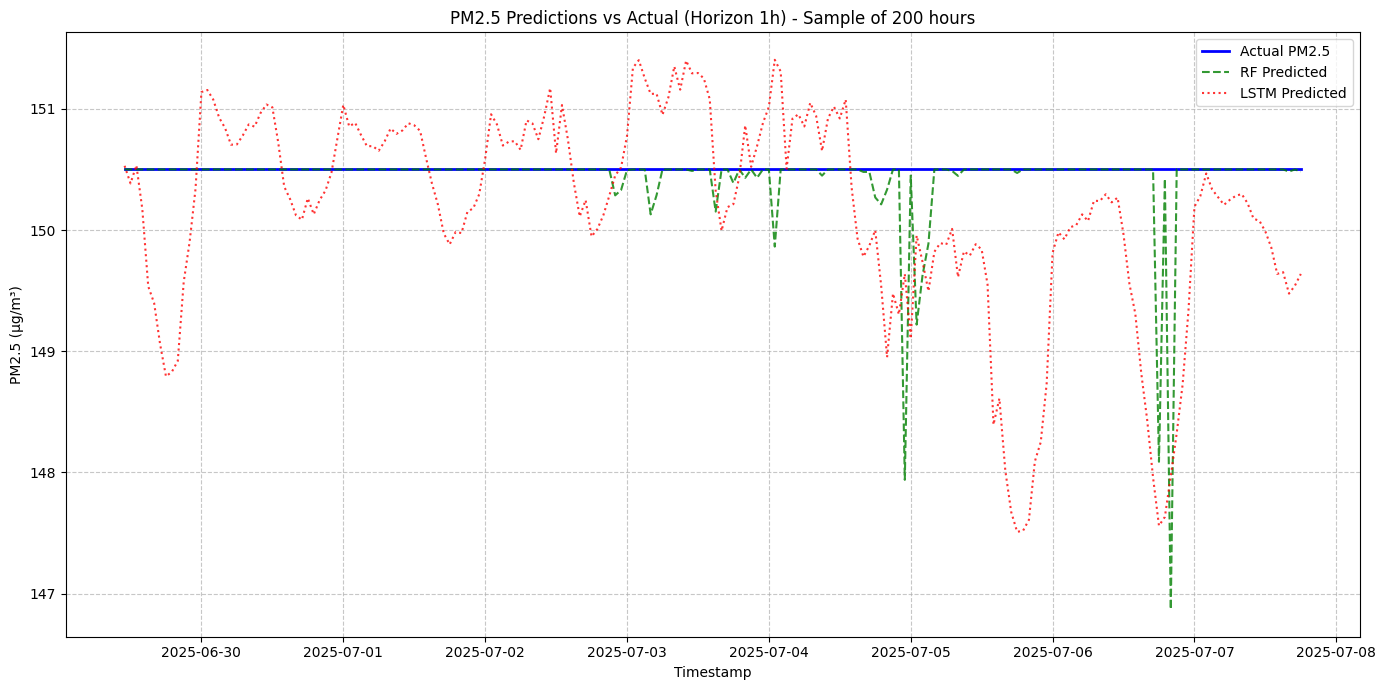


--- Evaluating Models for Horizon: 3 hours ---
Target scaler_y_h3.pkl loaded.
Evaluating RandomForestRegressor for horizon 3...


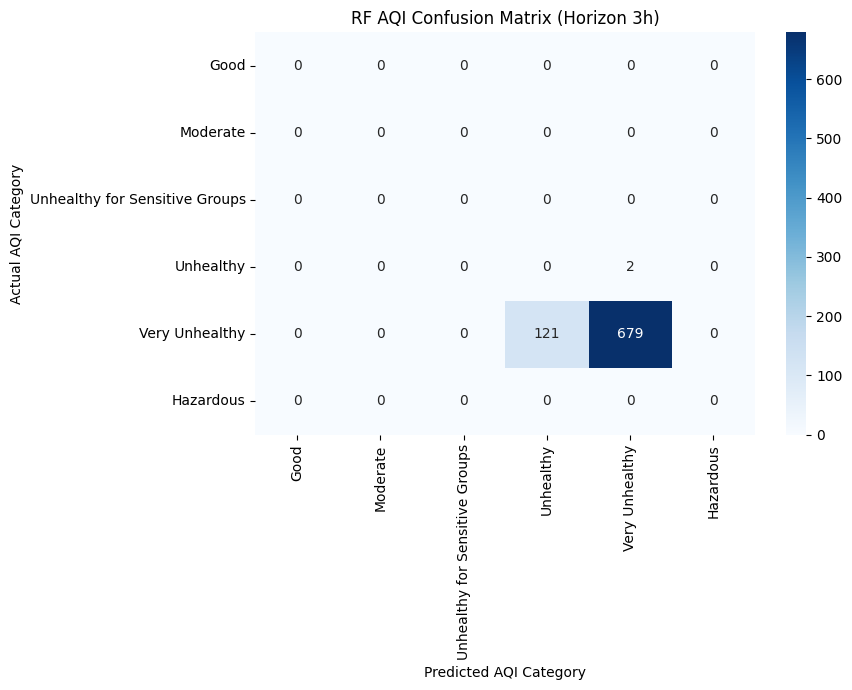

RF Horizon 3: MAE=0.24, RMSE=1.34, AQI Acc=0.85, AQI F1=0.91
Evaluating LSTM Neural Network for horizon 3...


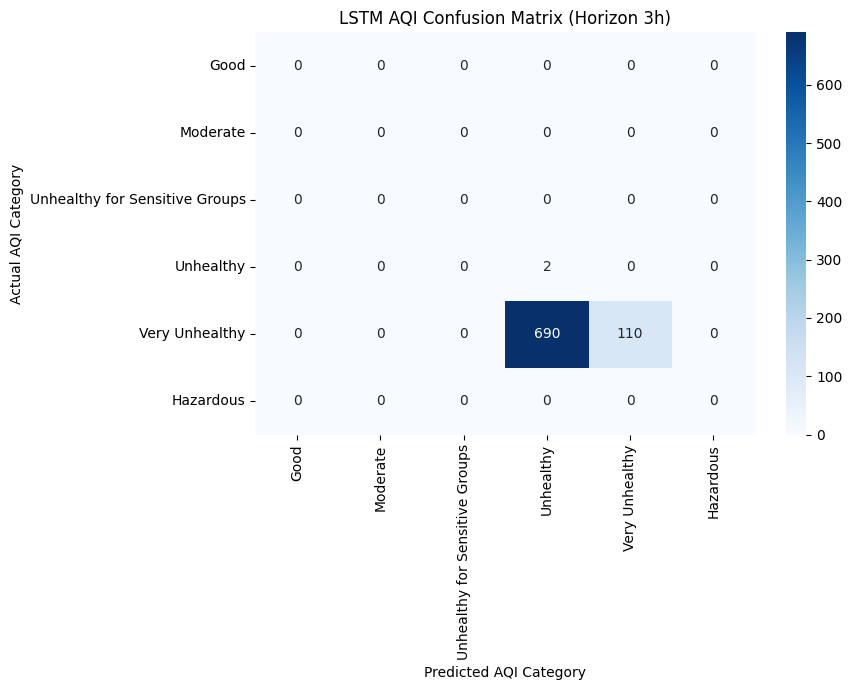

LSTM Horizon 3: MAE=0.51, RMSE=1.00, AQI Acc=0.14, AQI F1=0.24


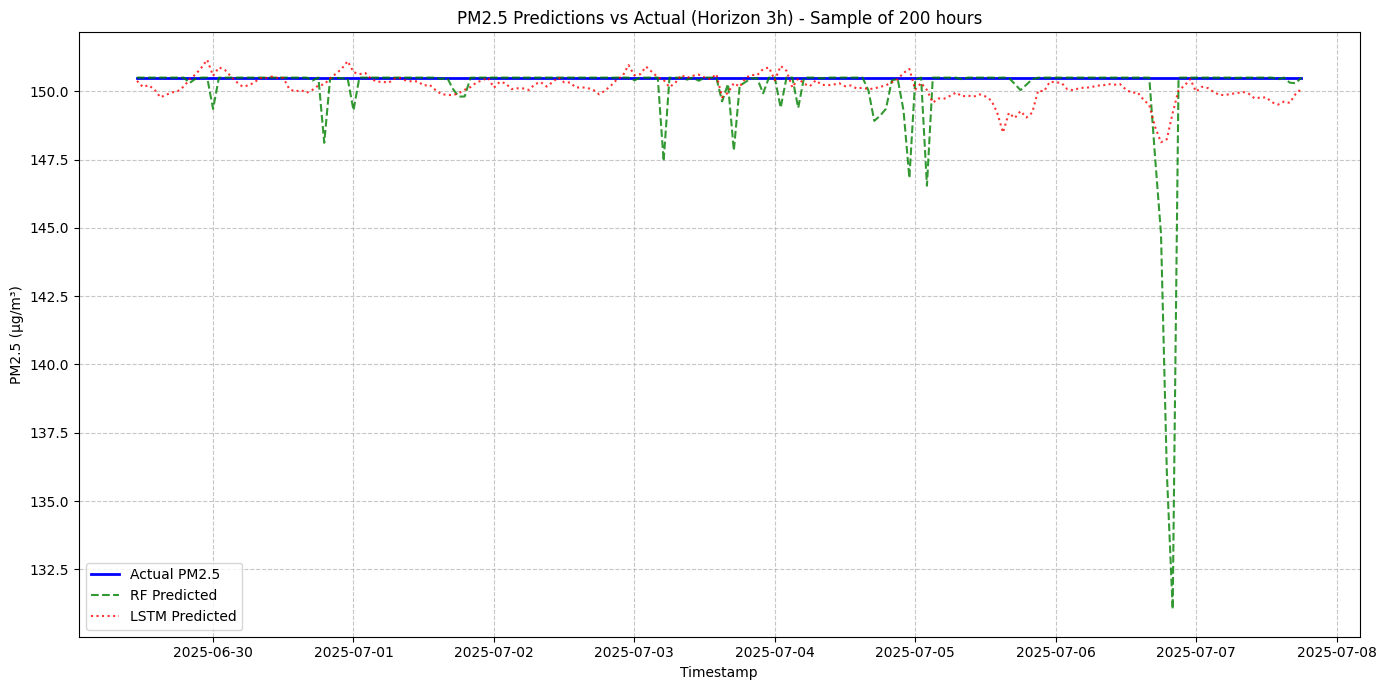


--- Evaluating Models for Horizon: 6 hours ---
Target scaler_y_h6.pkl loaded.
Evaluating RandomForestRegressor for horizon 6...


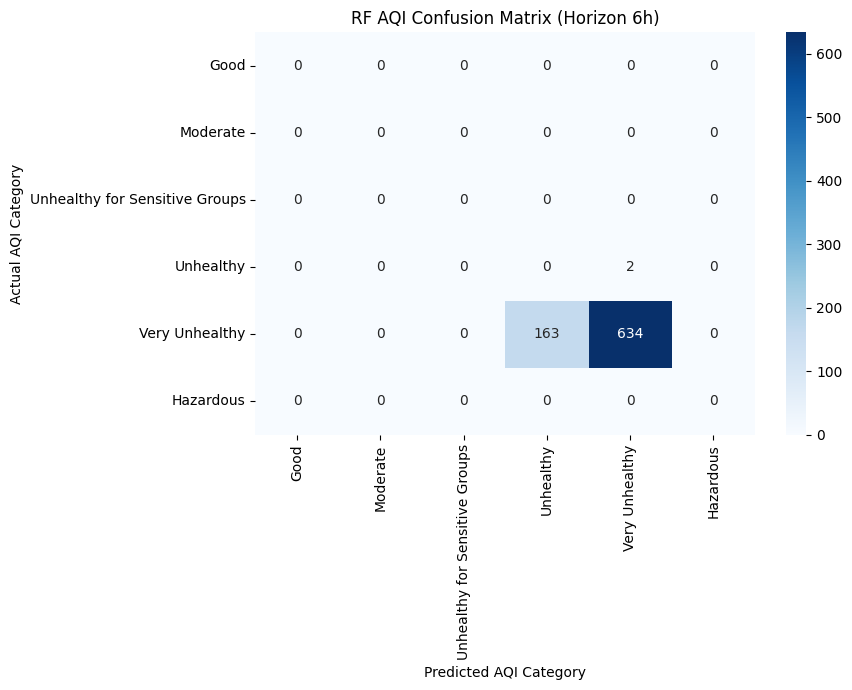

RF Horizon 6: MAE=0.37, RMSE=1.63, AQI Acc=0.79, AQI F1=0.88
Evaluating LSTM Neural Network for horizon 6...


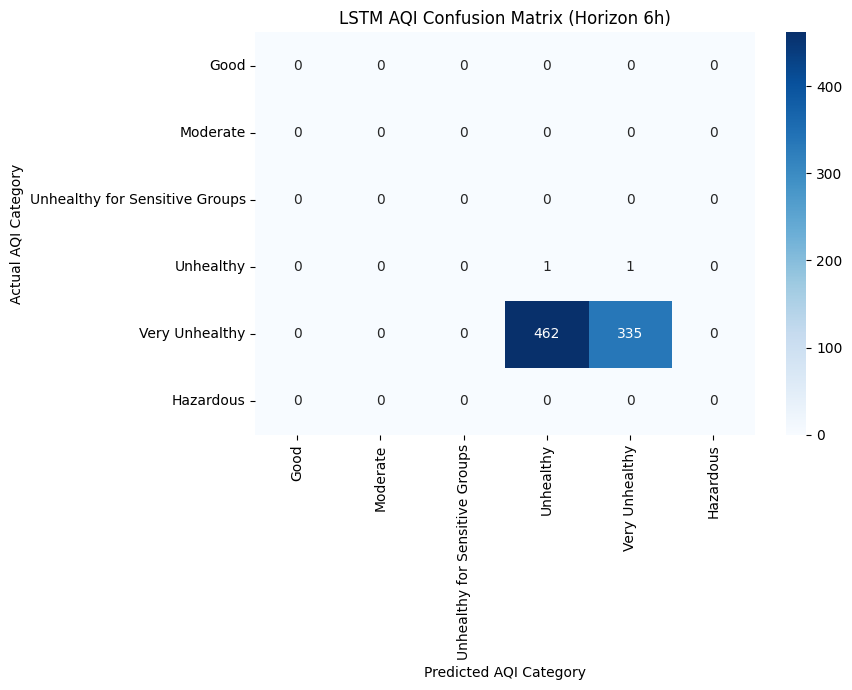

LSTM Horizon 6: MAE=0.40, RMSE=0.97, AQI Acc=0.42, AQI F1=0.59


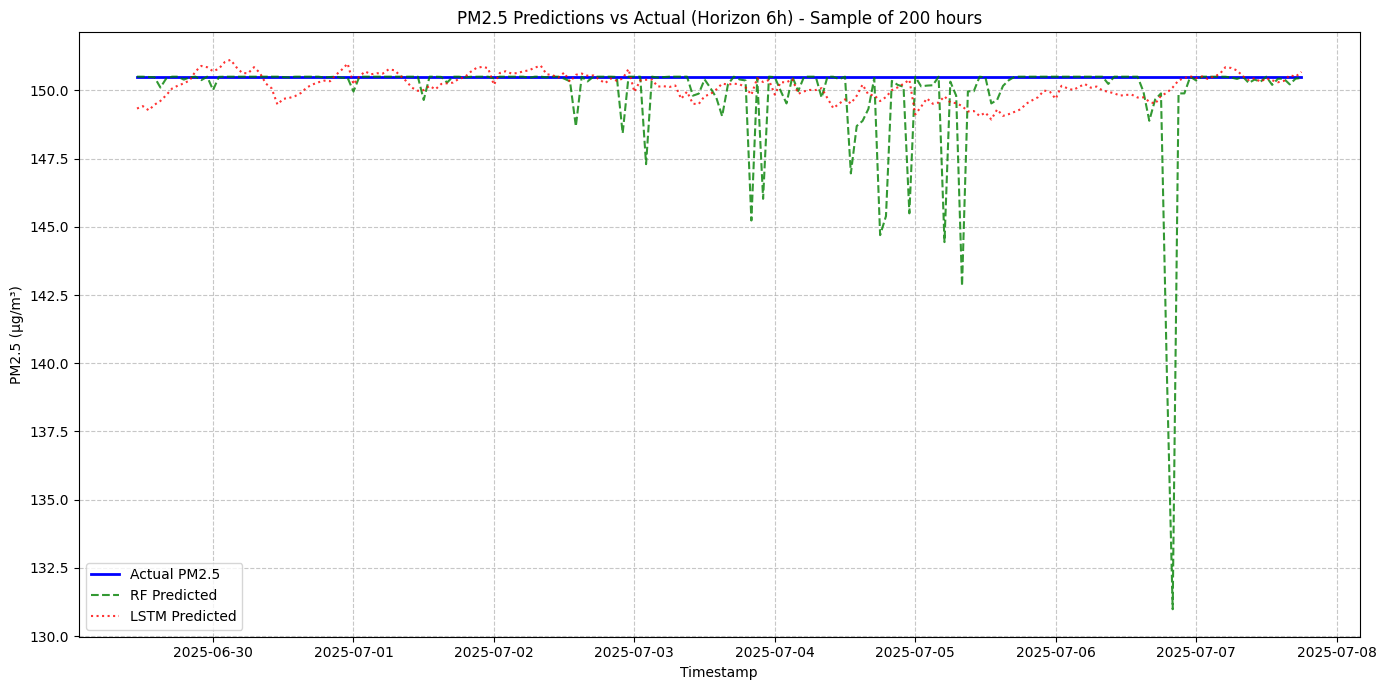


--- Evaluating Models for Horizon: 12 hours ---
Target scaler_y_h12.pkl loaded.
Evaluating RandomForestRegressor for horizon 12...


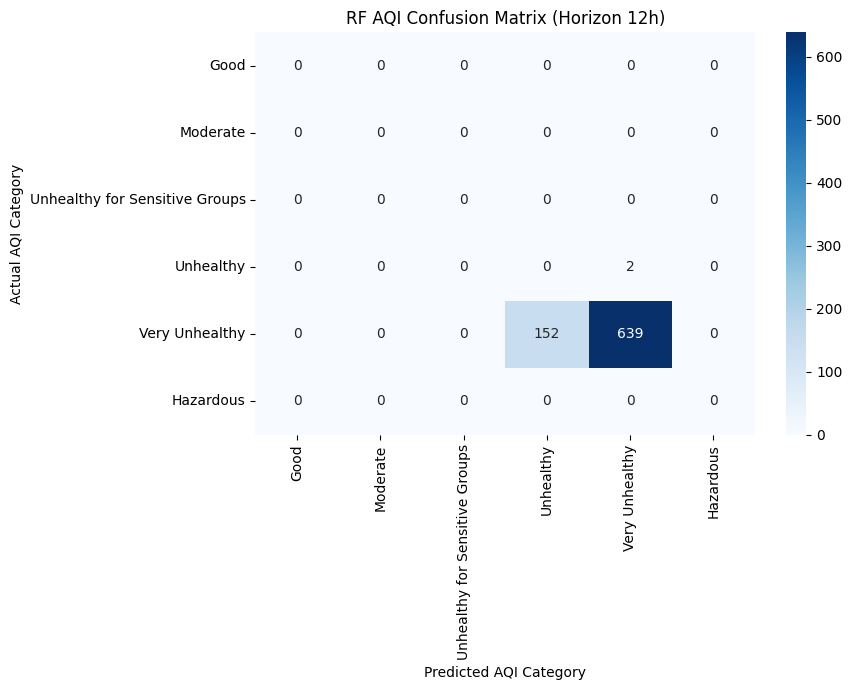

RF Horizon 12: MAE=0.32, RMSE=1.53, AQI Acc=0.81, AQI F1=0.89
Evaluating LSTM Neural Network for horizon 12...


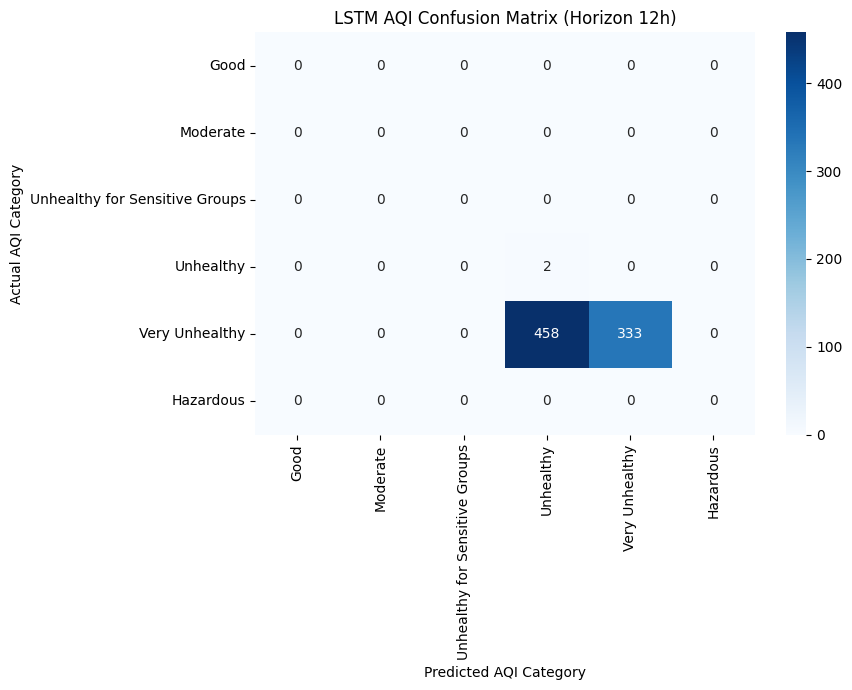

LSTM Horizon 12: MAE=0.50, RMSE=1.04, AQI Acc=0.42, AQI F1=0.59


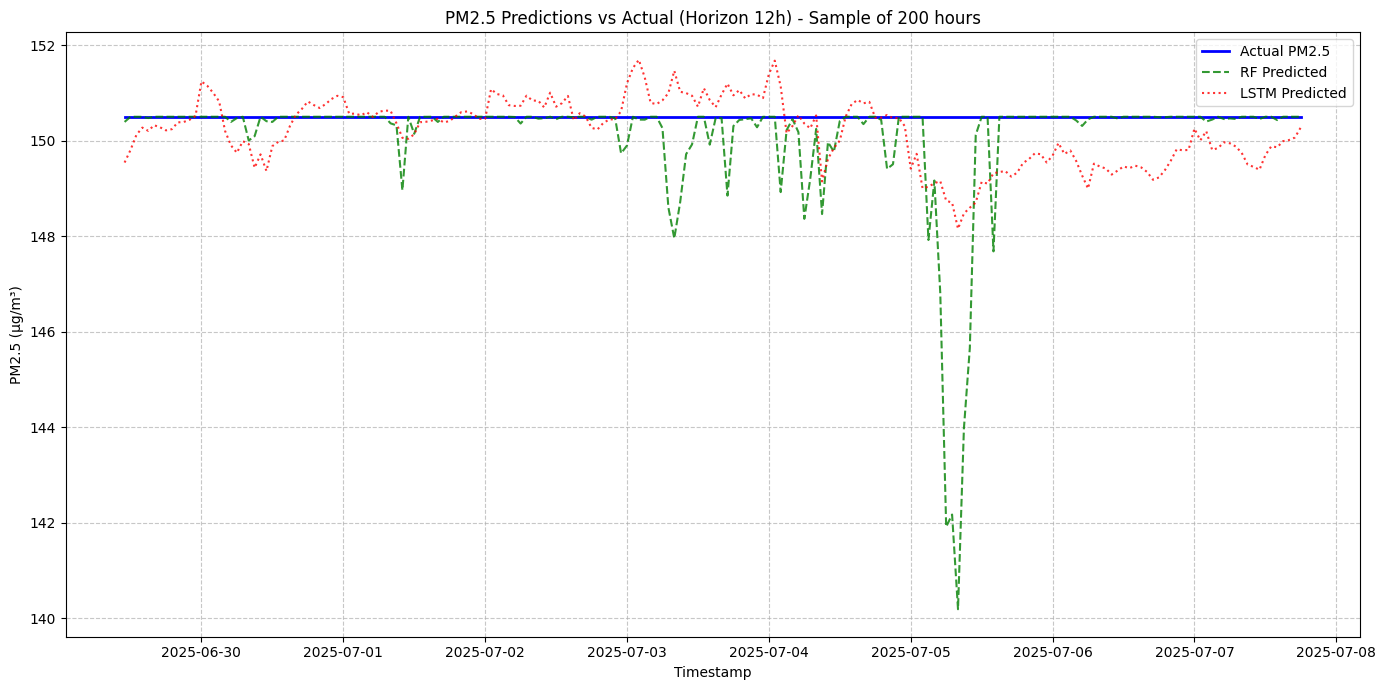


--- Evaluating Models for Horizon: 24 hours ---
Target scaler_y_h24.pkl loaded.
Evaluating RandomForestRegressor for horizon 24...


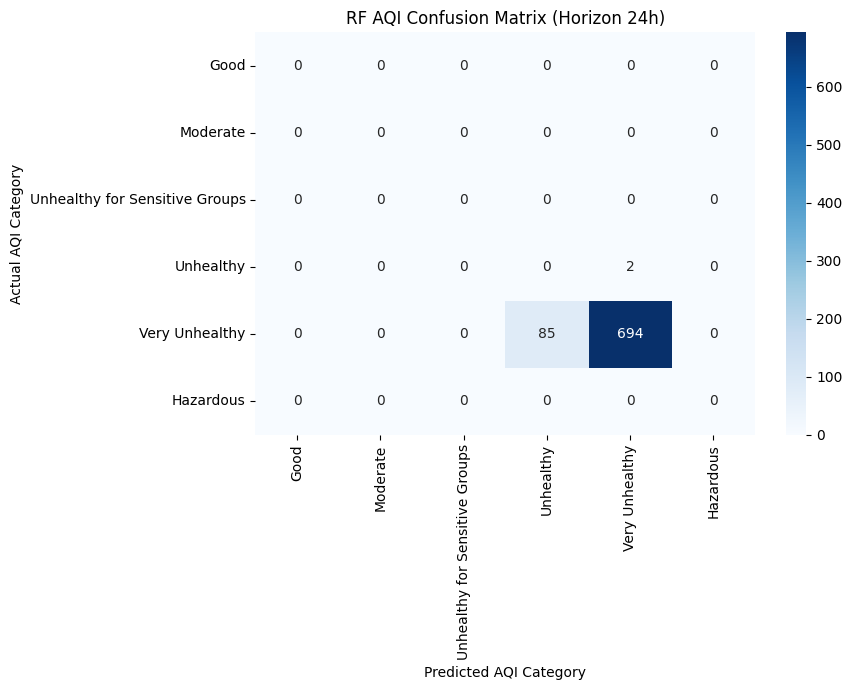

RF Horizon 24: MAE=0.23, RMSE=1.23, AQI Acc=0.89, AQI F1=0.94
Evaluating LSTM Neural Network for horizon 24...


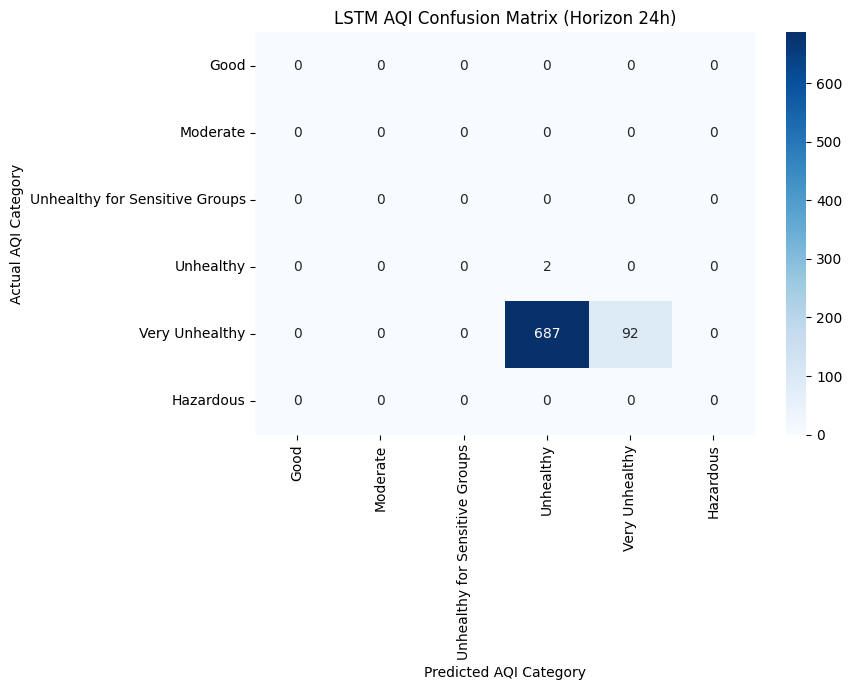

LSTM Horizon 24: MAE=0.63, RMSE=1.09, AQI Acc=0.12, AQI F1=0.21


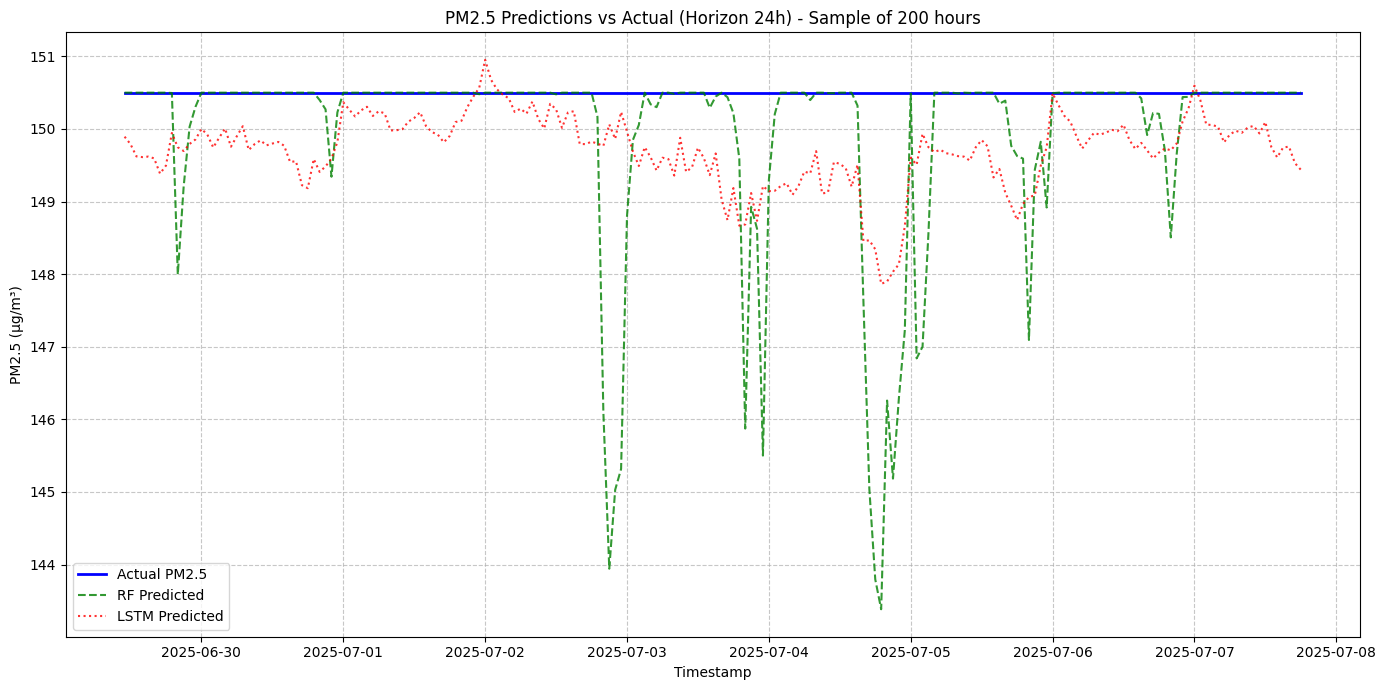


--- Overall Evaluation Results Summary ---
   Horizon Model       MAE      RMSE  AQI Accuracy    AQI F1
0        1    RF  0.478077  2.063697      0.905473  0.948027
1        1  LSTM  0.575056  1.103845      0.434080  0.602523
2        3    RF  0.237861  1.343085      0.846633  0.914661
3        3  LSTM  0.514970  1.003771      0.139651  0.241170
4        6    RF  0.367357  1.627268      0.793492  0.882642
5        6  LSTM  0.396908  0.965490      0.420526  0.589881
6       12    RF  0.317391  1.532499      0.805801  0.890207
7       12  LSTM  0.498096  1.039573      0.422446  0.591054
8       24    RF  0.232511  1.226973      0.888604  0.938607
9       24  LSTM  0.629506  1.092939      0.120359  0.210725
Evaluation results saved to evaluation_results_summary.csv.

--- Performing Explainable AI (SHAP) ---

Calculating SHAP values for Random Forest (Horizon 6h)...


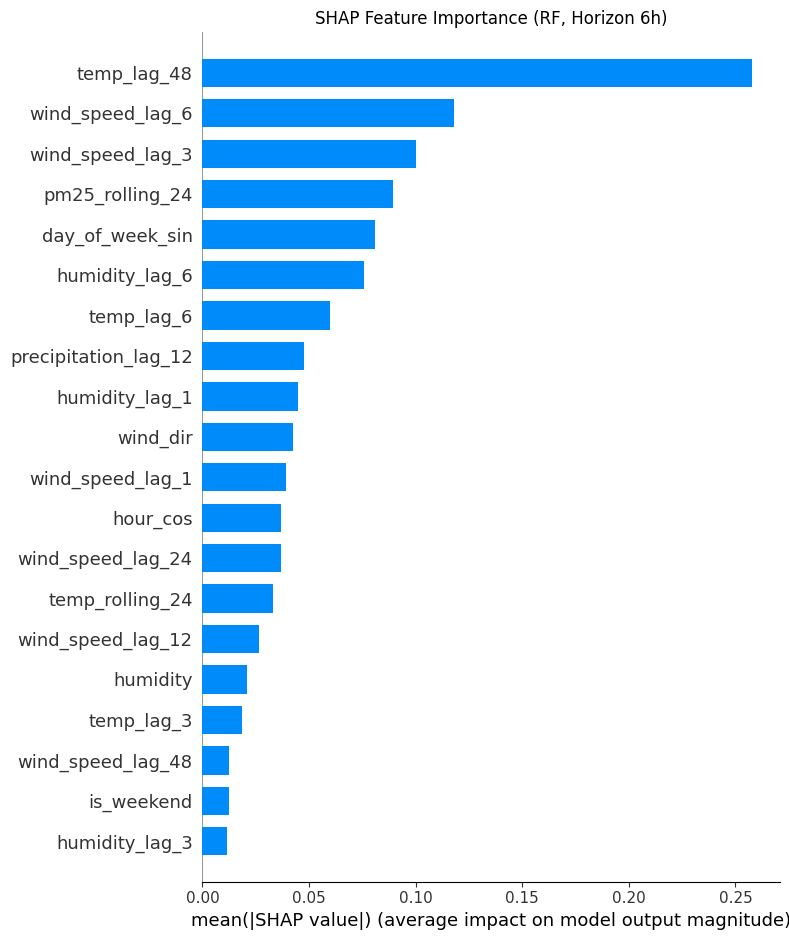

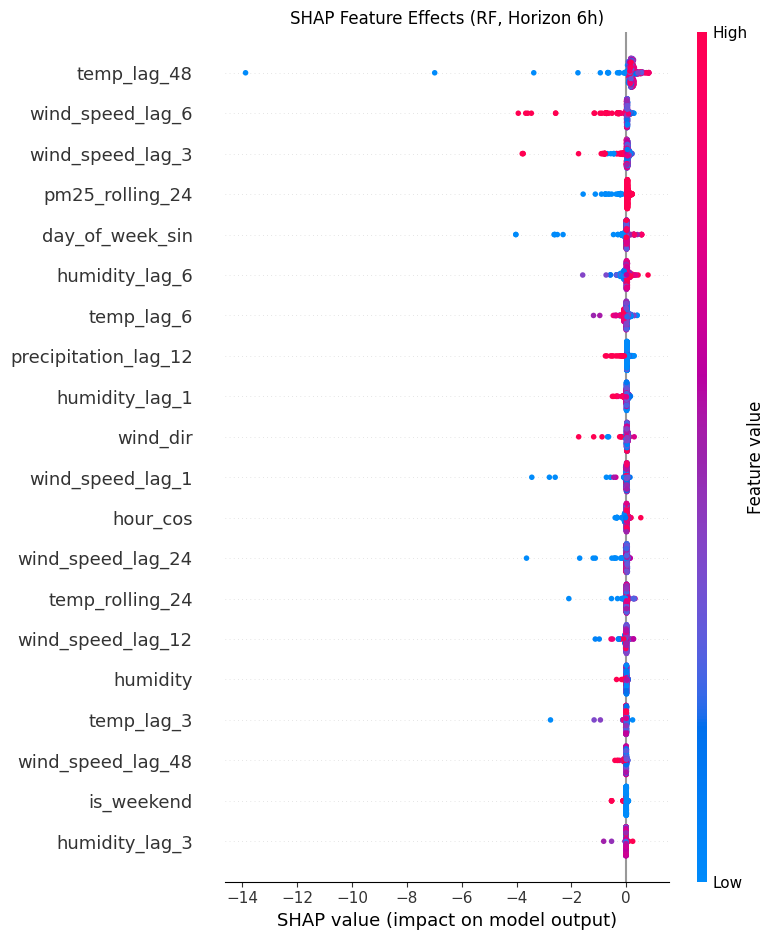

SHAP for Random Forest (Horizon 6h) completed and plots saved.

Calculating SHAP values for LSTM (Horizon 6h)...


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import joblib
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os  # For path joining

print("--- Starting Assessment and Evaluation (Notebook 4) ---")

# Load the pre-processed test data from Notebook 3 (already featured and scaled)
# IMPORTANT: This filename must match what Notebook 3 saved!
input_test_filename = 'test_featured_data.csv'

try:
    df_test = pd.read_csv(input_test_filename, index_col='timestamp', parse_dates=True)
    print(f"Loaded test featured data successfully. Shape: {df_test.shape}")
    print(f"Columns in loaded data: {df_test.columns.tolist()}")
except Exception as e:
    print(f"Error loading test featured data from {input_test_filename}: {e}")
    print("Please ensure Notebook 3 has run successfully and saved 'test_featured_data.csv'.")
    raise SystemExit("Failed to load test featured data. Aborting Notebook 4 execution.")

# Define features based on the loaded test data (exclude 'pm25_value' and any 'target_h')
features_base = [col for col in df_test.columns if col not in ['pm25_value'] and 'target_h' not in col]

# Load the scaler_x from Notebook 3 (though test is already scaled, for consistency/reference)
try:
    scaler_x = joblib.load('scaler_x.pkl')
    print("Feature scaler_x loaded successfully.")
except Exception as e:
    print(f"Error loading scaler_x.pkl: {e}")
    # Not critical since test is pre-scaled, but warn
    print("Proceeding without scaler_x, assuming test data is already scaled.")

# Full AQI calculation for PM2.5 (US EPA breakpoints; Justification: Standard for classification, enables sustainability alerts)
# Source: https://www.epa.gov/pm-pollution-and-your-health/how-air-now-calculates-aqi-pm25
def calculate_pm25_aqi(pm25):
    if pm25 < 0: return np.nan # Handle negative values if any slipped through
    if pm25 <= 12.0:
        return (50 / 12.0) * pm25
    elif pm25 <= 35.4:
        return 50 + (50 / (35.4 - 12.0)) * (pm25 - 12.0)
    elif pm25 <= 55.4:
        return 100 + (50 / (55.4 - 35.4)) * (pm25 - 35.4)
    elif pm25 <= 150.4:
        return 150 + (50 / (150.4 - 55.4)) * (pm25 - 55.4)
    elif pm25 <= 250.4:
        return 200 + (100 / (250.4 - 150.4)) * (pm25 - 150.4)
    elif pm25 <= 350.4:
        return 300 + (100 / (350.4 - 250.4)) * (pm25 - 250.4)
    elif pm25 <= 500.4:
        return 400 + (100 / (500.4 - 350.4)) * (pm25 - 350.4)
    else:
        return 500 # Cap at 500 for values beyond scale

def get_aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

# Order of categories for consistent reporting and plotting
aqi_categories_list = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

results = []
horizons = [1, 3, 6, 12, 24]

# Loop through each prediction horizon
for h in horizons:
    print(f"\n--- Evaluating Models for Horizon: {h} hours ---")

    # Define the actual target for this horizon from the full test_df
    # Ensure y_test_h aligns correctly with X_test_h length.
    # The actual target is pm25_value shifted 'h' hours into the future, from the test set.
    # We need to ensure we only take the part of the original test_df that has a corresponding target.
    # This means X_test_scaled_df should be trimmed to match the length of available targets.

    # Create the target series for this horizon from the full df, then take the test portion
    y_test_h_actual = df_test['pm25_value'].shift(-h).dropna()

    # Now, align X_test_h with y_test_h_actual's index (this is crucial for correct pairing)
    X_test_h = df_test.loc[y_test_h_actual.index, features_base]

    # Re-verify lengths (important for metrics)
    if len(X_test_h) != len(y_test_h_actual):
        print(f"Warning: X_test_h ({len(X_test_h)}) and y_test_h_actual ({len(y_test_h_actual)}) lengths mismatch for horizon {h}. Skipping.")
        continue # Skip this horizon if data is misaligned

    # Add variance check for y_test_h_actual to detect flat data
    if y_test_h_actual.var() < 1e-5:
        print(f"Warning: Flat test data detected for horizon {h}h (variance: {y_test_h_actual.var():.2e}). Results may be unreliable. Skipping or investigate data source.")
        continue  # Skip evaluation for this horizon if flat

    # Load scaler_y for this horizon
    try:
        scaler_y = joblib.load(f'scaler_y_h{h}.pkl')
        print(f"Target scaler_y_h{h}.pkl loaded.")
    except Exception as e:
        print(f"Error loading scaler_y_h{h}.pkl: {e}")
        continue # Skip if scaler not found


    # --- Random Forest Evaluation ---
    print(f"Evaluating RandomForestRegressor for horizon {h}...")
    try:
        rf = joblib.load(f'rf_model_h{h}.pkl')
        rf_pred = rf.predict(X_test_h)  # RF was trained on unscaled y, so preds are unscaled

        mae_rf = mean_absolute_error(y_test_h_actual, rf_pred)
        rmse_rf = np.sqrt(mean_squared_error(y_test_h_actual, rf_pred))

        # AQI Classification Metrics for RF
        y_actual_aqi_values = y_test_h_actual.apply(calculate_pm25_aqi).dropna()
        y_actual_aqi_cats = y_actual_aqi_values.apply(get_aqi_category)

        y_pred_rf_aqi_values = pd.Series(rf_pred, index=y_test_h_actual.index).apply(calculate_pm25_aqi).dropna()
        y_pred_rf_aqi_cats = y_pred_rf_aqi_values.apply(get_aqi_category)

        # Align indices for classification report
        common_idx_rf_aqi = y_actual_aqi_cats.index.intersection(y_pred_rf_aqi_cats.index)

        if not common_idx_rf_aqi.empty:
            report_rf = classification_report(
                y_actual_aqi_cats.loc[common_idx_rf_aqi],
                y_pred_rf_aqi_cats.loc[common_idx_rf_aqi],
                labels=aqi_categories_list,
                zero_division=0,
                output_dict=True
            )
            aqi_acc_rf = report_rf['accuracy']
            aqi_f1_rf = report_rf['weighted avg']['f1-score'] # Use weighted avg for F1

            cm_rf = confusion_matrix(
                y_actual_aqi_cats.loc[common_idx_rf_aqi],
                y_pred_rf_aqi_cats.loc[common_idx_rf_aqi],
                labels=aqi_categories_list
            )
            plt.figure(figsize=(9, 7)) # Slightly larger for readability
            sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
                        xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
            plt.title(f'RF AQI Confusion Matrix (Horizon {h}h)')
            plt.xlabel('Predicted AQI Category')
            plt.ylabel('Actual AQI Category')
            plt.tight_layout()
            plt.savefig(f'rf_cm_h{h}.png')
            plt.show()
        else:
            aqi_acc_rf, aqi_f1_rf = np.nan, np.nan
            print(f"No common AQI categories for RF at horizon {h} for classification report.")

        results.append({
            'Horizon': h, 'Model': 'RF',
            'MAE': mae_rf, 'RMSE': rmse_rf,
            'AQI Accuracy': aqi_acc_rf, 'AQI F1': aqi_f1_rf
        })
        print(f"RF Horizon {h}: MAE={mae_rf:.2f}, RMSE={rmse_rf:.2f}, AQI Acc={aqi_acc_rf:.2f}, AQI F1={aqi_f1_rf:.2f}")

    except Exception as e:
        print(f"Error evaluating RF for horizon {h}: {e}")
        results.append({'Horizon': h, 'Model': 'RF', 'MAE': np.nan, 'RMSE': np.nan, 'AQI Accuracy': np.nan, 'AQI F1': np.nan})


    # --- LSTM Evaluation ---
    print(f"Evaluating LSTM Neural Network for horizon {h}...")
    try:
        # Load LSTM model
        lstm = load_model(f'lstm_model_h{h}.keras')  # Updated format from fixed Notebook 3

        # Reshape X_test_h for LSTM input (samples, timesteps, features)
        # timesteps = 1 for our current setup
        X_test_h_lstm = np.reshape(X_test_h.values, (X_test_h.shape[0], 1, X_test_h.shape[1]))

        lstm_pred_scaled = lstm.predict(X_test_h_lstm, verbose=0) # Suppress prediction verbose
        lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled).flatten()

        mae_lstm = mean_absolute_error(y_test_h_actual, lstm_pred)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_h_actual, lstm_pred))

        # AQI Classification Metrics for LSTM
        y_pred_lstm_aqi_values = pd.Series(lstm_pred, index=y_test_h_actual.index).apply(calculate_pm25_aqi).dropna()
        y_pred_lstm_aqi_cats = y_pred_lstm_aqi_values.apply(get_aqi_category)

        # Align indices for classification report
        common_idx_lstm_aqi = y_actual_aqi_cats.index.intersection(y_pred_lstm_aqi_cats.index)

        if not common_idx_lstm_aqi.empty:
            report_lstm = classification_report(
                y_actual_aqi_cats.loc[common_idx_lstm_aqi],
                y_pred_lstm_aqi_cats.loc[common_idx_lstm_aqi],
                labels=aqi_categories_list,
                zero_division=0,
                output_dict=True
            )
            aqi_acc_lstm = report_lstm['accuracy']
            aqi_f1_lstm = report_lstm['weighted avg']['f1-score']

            cm_lstm = confusion_matrix(
                y_actual_aqi_cats.loc[common_idx_lstm_aqi],
                y_pred_lstm_aqi_cats.loc[common_idx_lstm_aqi],
                labels=aqi_categories_list
            )
            plt.figure(figsize=(9, 7))
            sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
            plt.title(f'LSTM AQI Confusion Matrix (Horizon {h}h)')
            plt.xlabel('Predicted AQI Category')
            plt.ylabel('Actual AQI Category')
            plt.tight_layout()
            plt.savefig(f'lstm_cm_h{h}.png')
            plt.show()
        else:
            aqi_acc_lstm, aqi_f1_lstm = np.nan, np.nan
            print(f"No common AQI categories for LSTM at horizon {h} for classification report.")

        results.append({
            'Horizon': h, 'Model': 'LSTM',
            'MAE': mae_lstm, 'RMSE': rmse_lstm,
            'AQI Accuracy': aqi_acc_lstm, 'AQI F1': aqi_f1_lstm
        })
        print(f"LSTM Horizon {h}: MAE={mae_lstm:.2f}, RMSE={rmse_lstm:.2f}, AQI Acc={aqi_acc_lstm:.2f}, AQI F1={aqi_f1_lstm:.2f}")

    except Exception as e:
        print(f"Error evaluating LSTM for horizon {h}: {e}")
        results.append({'Horizon': h, 'Model': 'LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'AQI Accuracy': np.nan, 'AQI F1': np.nan})

    # Plot Predictions vs Actual (for visualization in report)
    # Justification: Visual comparison of predicted vs. actual values provides immediate insight
    # into model accuracy, bias, and ability to capture trends and peaks, complementing quantitative metrics.
    # This directly helps in "visual error analysis" and highlighting "model strengths"[cite: 32, 46].
    if 'rf_pred' in locals() and 'lstm_pred' in locals() and not y_test_h_actual.empty:
        # Limit the plot to a smaller window (e.g., 200 data points) for readability if dataset is very large
        plot_start_idx = 0
        plot_end_idx = min(len(y_test_h_actual), 200) # Plot only the first 200 points for clarity

        plt.figure(figsize=(14, 7)) # Larger figure for better detail
        plt.plot(y_test_h_actual.index[plot_start_idx:plot_end_idx], y_test_h_actual.iloc[plot_start_idx:plot_end_idx], label='Actual PM2.5', color='blue', linewidth=2)
        plt.plot(y_test_h_actual.index[plot_start_idx:plot_end_idx], rf_pred[plot_start_idx:plot_end_idx], label='RF Predicted', color='green', linestyle='--', alpha=0.8)
        plt.plot(y_test_h_actual.index[plot_start_idx:plot_end_idx], lstm_pred[plot_start_idx:plot_end_idx], label='LSTM Predicted', color='red', linestyle=':', alpha=0.8)

        plt.title(f'PM2.5 Predictions vs Actual (Horizon {h}h) - Sample of {plot_end_idx} hours')
        plt.xlabel('Timestamp')
        plt.ylabel('PM2.5 (µg/m³)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'preds_h{h}.png')
        plt.show()
    else:
        print(f"Skipping prediction plot for horizon {h} due to missing data or predictions.")


# --- Save and print overall results ---
results_df = pd.DataFrame(results)
results_output_filename = 'evaluation_results_summary.csv'
results_df.to_csv(results_output_filename, index=False)
print(f"\n--- Overall Evaluation Results Summary ---")
print(results_df)
print(f"Evaluation results saved to {results_output_filename}.")


# --- Explainable AI (XAI) using SHAP ---
# Justification: SHAP values provide a unified measure of feature importance and impact,
# explaining individual predictions and overall model behavior. This directly addresses
# the requirement for explainable AI techniques.
print("\n--- Performing Explainable AI (SHAP) ---")

# Determine a single horizon for explanation to save compute time.
# Choosing a mid-range horizon, e.g., 6 hours.
h_explain = 6
if h_explain not in horizons:
    print(f"Warning: Explanation horizon {h_explain} not in trained horizons. Using default 1-hour horizon for explanation.")
    h_explain = horizons[0] # Fallback to first available horizon

# For SHAP, reconstruct X_test and y_test_h_actual for the chosen h_explain
y_actual_full_shifted_explain = df_test['pm25_value'].shift(-h_explain)
y_test_h_actual_explain = y_actual_full_shifted_explain.dropna()
X_test_h_explain = df_test.loc[y_test_h_actual_explain.index, features_base]

if X_test_h_explain.empty:
    print(f"Skipping SHAP analysis: X_test_h_explain is empty for horizon {h_explain}.")
else:
    # --- SHAP for Random Forest ---
    print(f"\nCalculating SHAP values for Random Forest (Horizon {h_explain}h)...")
    try:
        rf_explain_model = joblib.load(f'rf_model_h{h_explain}.pkl')

        # Using a small sample of X_test_h_explain for SHAP to save compute
        shap_sample_rf = X_test_h_explain.sample(n=min(len(X_test_h_explain), 500), random_state=42) # Sample up to 500

        explainer_rf = shap.TreeExplainer(rf_explain_model)
        # For tree models, shap_values can be directly calculated on the features
        shap_values_rf = explainer_rf.shap_values(shap_sample_rf)

        # If the model is multi-output or produces different shap value types, ensure it's handled.
        # For regression, shap_values_rf is typically a single array.
        if isinstance(shap_values_rf, list) and len(shap_values_rf) == 1:
            shap_values_rf = shap_values_rf[0]

        plt.figure(figsize=(10, 8)) # Larger for better readability
        shap.summary_plot(shap_values_rf, shap_sample_rf, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance (RF, Horizon {h_explain}h)')
        plt.tight_layout()
        plt.savefig(f'shap_rf_h{h_explain}_bar.png')
        plt.show()

        plt.figure(figsize=(10, 8)) # For scatter plot type
        shap.summary_plot(shap_values_rf, shap_sample_rf, show=False) # Default scatter plot
        plt.title(f'SHAP Feature Effects (RF, Horizon {h_explain}h)')
        plt.tight_layout()
        plt.savefig(f'shap_rf_h{h_explain}_scatter.png')
        plt.show()

        print(f"SHAP for Random Forest (Horizon {h_explain}h) completed and plots saved.")

    except Exception as e:
        print(f"Error performing SHAP for Random Forest (Horizon {h_explain}h): {e}")

    # --- SHAP for LSTM (KernelExplainer - slower, requires small sample) ---
    print(f"\nCalculating SHAP values for LSTM (Horizon {h_explain}h)...")
    try:
        lstm_explain_model = load_model(f'lstm_model_h{h_explain}.keras')

        # Using a very small sample for KernelExplainer to manage compute time.
        # KernelExplainer needs a background dataset. Using a small subset of the training data or X_test.
        # The background data should represent the distribution of features.
        # For this, let's take a background sample from the earlier part of the df_test.
        background_sample_size = min(len(df_test), 50) # Use 50 samples from the test dataset for background
        background_data = df_test[features_base].sample(n=background_sample_size, random_state=42).values # Extract values

        # Define the LSTM prediction function for SHAP
        def lstm_predict_func(data):
            # Reshape input for LSTM: (samples, timesteps, features)
            # data comes in as (samples, features) from SHAP, need to reshape
            reshaped_data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
            # Make prediction and flatten to 1D array as expected by SHAP for regression
            return lstm_explain_model.predict(reshaped_data, verbose=0).flatten()

        # Explainer for LSTM - using a small background dataset for efficiency
        explainer_lstm = shap.KernelExplainer(lstm_predict_func, background_data)

        # Sample data to explain - even smaller for KernelExplainer's shap_values
        shap_sample_lstm = X_test_h_explain.sample(n=min(len(X_test_h_explain), 20), random_state=42) # Sample up to 20 points

        # Calculate SHAP values
        shap_values_lstm = explainer_lstm.shap_values(shap_sample_lstm.values) # Pass numpy array values

        # Convert shap_sample_lstm to DataFrame with correct columns for plotting
        shap_sample_lstm_df = pd.DataFrame(shap_sample_lstm, columns=features_base, index=shap_sample_lstm.index)

        plt.figure(figsize=(10, 8)) # Larger for better readability
        shap.summary_plot(shap_values_lstm, shap_sample_lstm_df, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance (LSTM, Horizon {h_explain}h)')
        plt.tight_layout()
        plt.savefig(f'shap_lstm_h{h_explain}_bar.png')
        plt.show()

        plt.figure(figsize=(10, 8)) # For scatter plot type
        shap.summary_plot(shap_values_lstm, shap_sample_lstm_df, show=False) # Default scatter plot
        plt.title(f'SHAP Feature Effects (LSTM, Horizon {h_explain}h)')
        plt.tight_layout()
        plt.savefig(f'shap_lstm_h{h_explain}_scatter.png')
        plt.show()

        print(f"SHAP for LSTM (Horizon {h_explain}h) completed and plots saved.")

    except Exception as e:
        print(f"Error performing SHAP for LSTM (Horizon {h_explain}h): {e}")
        print("This often happens if SHAP's KernelExplainer struggles with data size or specific model types.")


print("\n--- Assessment and Evaluation Complete ---")
print("All results, confusion matrices, prediction plots, and SHAP plots are saved to your Google Drive project folder.")